# Twitter Sentiment Analysis - 03 Preprocessing and Training Data

The objective of this notebook is to prepare data for fitting models. In notebook 02_Exploratory_Data_Analysis, we have already featured new columns for the stock data, measuring the changes each day. In this notebook, we will be using word embedding to convert words to vectors, then use that as an additional parameter to our training set. Word Embedding is a language modeling technique used for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions.

Guidance from Springboard:

Create dummy or indicator features for categorical variables \
Standardize the magnitude of numeric features using a scaler \
Split your data into testing and training datasets

**Link(s) to previous notebook(s)**: \
00_Historical_Data_2014: https://github.com/parisvu07/Springboard_Data_Science/tree/main/Capstone_2_Twitter_Sentiment_Analysis \
01_Data_Wrangling:
https://github.com/parisvu07/Springboard_Data_Science/blob/main/Capstone_2_Twitter_Sentiment_Analysis/01_Data_Wrangling.ipynb \
02_Exploratory_Data_Analysis: https://github.com/parisvu07/Springboard_Data_Science/blob/main/Capstone_2_Twitter_Sentiment_Analysis/02_Exploratory_Data_Analysis.ipynb

Quick fix for "Unable to render rich display": copy and paste the notebook link to https://nbviewer.org

## 3.1 Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re

import gensim
from gensim.models.doc2vec import TaggedDocument
LabeledSentence = gensim.models.doc2vec.TaggedDocument
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from nltk.tokenize import TweetTokenizer 

In [2]:
#Importing stock data from previous notebook "02_Exploratory_Data_Analysis"
eda_stock_data = pd.read_csv('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/02_stock_data.csv', encoding='latin-1')
eda_stock_data.reset_index(drop=True, inplace=True)
eda_stock_data.head()

,Dates,Time,Adj Close,Volume,%_change_Open,%_change_High,%_change_Low,%_change_Close,%_change_Volume
0,2022-12-01,00:00:00,148.309998,71250400,NaN,NaN,NaN,NaN,NaN
1,2022-12-02,00:00:00,147.809998,65447400,-1.518116,-0.757731,-0.654803,-0.337132,-8.144516
2,2022-12-05,00:00:00,146.630005,68826400,1.240064,1.972972,0.082396,-0.798317,5.162925
3,2022-12-06,00:00:00,142.910004,64727200,-0.473707,-2.398619,-2.641151,-2.536999,-5.955854
4,2022-12-07,00:00:00,140.940002,69721100,-3.318151,-2.668030,-1.352874,-1.378491,7.715304


In [3]:
#Importing tweet data from previous notebook "02_Exploratory_Data_Analysis"
trading_hours_tweets = pd.read_csv('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/trading_hours_tweets.csv', encoding='latin-1')
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,Sentiment
0,2022-12-30,20:29:43,LlcBillionaire,0,Twitter Web App,10 New Yearâs food traditions around the world,0.454545,0.136364,Positive,1.0
1,2022-12-30,20:29:32,skitontop1,0,Twitter Web App,Entries &amp; exits Daily! \nDiscord link belo...,0.500000,0.300000,Positive,1.0
2,2022-12-30,20:29:28,StockJobberOG,0,Twitter Web App,$AAPL $MSFT $SPY $TSLA $AMZN $BRK.B\n\n,0.000000,0.000000,Neutral,0.0
3,2022-12-30,20:29:20,ItsJennyJ,0,Twitter for Android,@Apple I have an Apple ipod from 2012.\nI'd li...,0.000000,0.000000,Neutral,0.0
4,2022-12-30,20:29:11,LlcBillionaire,0,Twitter Web App,The biggest â and maybe the best â financi...,0.150000,0.500000,Positive,1.0


In [4]:
trading_hours_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80425 entries, 0 to 80424
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Dates         80425 non-null  object 
 1   Time          80425 non-null  object 
 2   user          80425 non-null  object 
 3   likes         80425 non-null  int64  
 4   source        80425 non-null  object 
 5   text          80256 non-null  object 
 6   Subjectivity  80425 non-null  float64
 7   Polarity      80425 non-null  float64
 8   Analysis      80425 non-null  object 
 9   Sentiment     80425 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 6.1+ MB


In [5]:
trading_hours_tweets.dtypes

Dates            object
Time             object
user             object
likes             int64
source           object
text             object
Subjectivity    float64
Polarity        float64
Analysis         object
Sentiment       float64
dtype: object

In [6]:
trading_hours_tweets[trading_hours_tweets.isna().any(axis=1)]
trading_hours_tweets.dropna()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,Sentiment
0,2022-12-30,20:29:43,LlcBillionaire,0,Twitter Web App,10 New Yearâs food traditions around the world,0.454545,0.136364,Positive,1.0
1,2022-12-30,20:29:32,skitontop1,0,Twitter Web App,Entries &amp; exits Daily! \nDiscord link belo...,0.500000,0.300000,Positive,1.0
2,2022-12-30,20:29:28,StockJobberOG,0,Twitter Web App,$AAPL $MSFT $SPY $TSLA $AMZN $BRK.B\n\n,0.000000,0.000000,Neutral,0.0
3,2022-12-30,20:29:20,ItsJennyJ,0,Twitter for Android,@Apple I have an Apple ipod from 2012.\nI'd li...,0.000000,0.000000,Neutral,0.0
4,2022-12-30,20:29:11,LlcBillionaire,0,Twitter Web App,The biggest â and maybe the best â financi...,0.150000,0.500000,Positive,1.0
...,...,...,...,...,...,...,...,...,...,...
80420,2022-12-29,13:30:04,jrpurdon,0,Twitter Web App,@deazasvo @shaun_vids But no one was trying to...,0.512500,-0.150000,Negative,-1.0
80421,2022-12-29,13:30:03,drinkie,2,Twitter for iPad,That is brilliant from @Apple got my mouse mov...,0.650000,0.950000,Positive,1.0
80422,2022-12-29,13:30:03,healthysupplies,1,Buffer,Our #RecipeOfTheDay is apple and cinnamon spic...,0.569444,0.227778,Positive,1.0
80423,2022-12-29,13:30:02,NicheMktMedia,0,Buffer,What Are The Best Apple IPhone Cases,0.300000,1.000000,Positive,1.0


In [7]:
trading_hours_tweets['text'] = trading_hours_tweets['text'].values.astype(str)
trading_hours_tweets['text'].dtypes

dtype('O')

## 3.2 Feature Extractions


Text Mining is the process of deriving meaningful information from natural language text. Natural Language Processing (NLP) is a part of computer science and artificial intelligence which deals with human languages.

### 3.2.1 Counts

In [8]:
#Count the number of characters present in a tweet.
def count_chars(text):
    return len(text)

#Count the number of words present in each line of tweet
def count_words(text):
    return len(str(text).split())

#Count the number of punctuation
import string
def count_punctuations(text):
    punctuations = string.punctuation
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

#Count the number of words in quotation marks
def count_words_in_quotes(text):
    x = re.findall(('.'|"."), text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count
    
#Count the number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

#Count the number of unique words
def count_unique_words(text):
    return len(set(text.split()))

#Count of hashtags
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x)

#Count of mentions
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

#Count of stopwords
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

### 3.2.2 Implementations

In [9]:
trading_hours_tweets['char_count'] = trading_hours_tweets["text"].apply(lambda x:count_chars(x))
trading_hours_tweets['word_count'] = trading_hours_tweets["text"].apply(lambda x:count_words(x))
trading_hours_tweets['sent_count'] = trading_hours_tweets["text"].apply(lambda x:count_sent(x))
trading_hours_tweets['stopword_count'] = trading_hours_tweets["text"].apply(lambda x:count_stopwords(x))
trading_hours_tweets['unique_word_count'] = trading_hours_tweets["text"].apply(lambda x:count_unique_words(x))
trading_hours_tweets['htag_count'] = trading_hours_tweets["text"].apply(lambda x:count_htags(x))
trading_hours_tweets['mention_count'] = trading_hours_tweets["text"].apply(lambda x:count_mentions(x))
trading_hours_tweets['punct_count'] = trading_hours_tweets["text"].apply(lambda x:count_punctuations(x))

In [10]:
#Count of average word length
trading_hours_tweets['avg_wordlength'] = trading_hours_tweets['char_count']/trading_hours_tweets['word_count']

#Count of average sentence length
trading_hours_tweets['avg_sentlength'] = trading_hours_tweets['word_count']/trading_hours_tweets['sent_count']

#Ratio of unique words to total word count
trading_hours_tweets['unique_vs_words'] = trading_hours_tweets['unique_word_count']/trading_hours_tweets['word_count']

#Ratio of stopwords to total word count
trading_hours_tweets['stopwords_vs_words'] = trading_hours_tweets['stopword_count']/trading_hours_tweets['word_count']

In [11]:
trading_hours_tweets['avg_wordlength'] = trading_hours_tweets['char_count']/trading_hours_tweets['word_count']
trading_hours_tweets['avg_sentlength'] = trading_hours_tweets['word_count']/trading_hours_tweets['sent_count']
trading_hours_tweets['unique_vs_words'] = trading_hours_tweets['unique_word_count']/trading_hours_tweets['word_count']
trading_hours_tweets['stopwords_vs_words'] = trading_hours_tweets['stopword_count']/trading_hours_tweets['word_count']

### 3.2.3 Tokenization

Here we turn our twitter strings to lists of individual tokens (words, punctuations). Tokenization is the first step in NLP. It is the process of breaking strings into tokens which in turn are small structures or units. Tokenization involves three steps which are breaking a complex sentence into words, understanding the importance of each word with respect to the sentence and finally produce structural description on an input sentence.

Performing a simple pre-processing step, like removing links, removing user name, numbers, double space, punctuation, lower casing, etc.

In [12]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'httpS+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RTs@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet
my_punctuation = string.punctuation
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+ my_punctuation + ']+',' ', sent) # strip punctuation
    sent = re.sub('s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: remove_links(x))
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: remove_users(x))
trading_hours_tweets['clean_text'] = trading_hours_tweets['text'].apply(lambda x: preprocess(x))

In [13]:
from nltk.tokenize import RegexpTokenizer

#NLTK tokenizer
tokenizer = RegexpTokenizer(r'\w+')
trading_hours_tweets['tokens'] = trading_hours_tweets['clean_text'].apply(tokenizer.tokenize)

### 3.2.4 Sentence Length

Using the tokens that we generated, we want to explore sentence length and vocabulary size

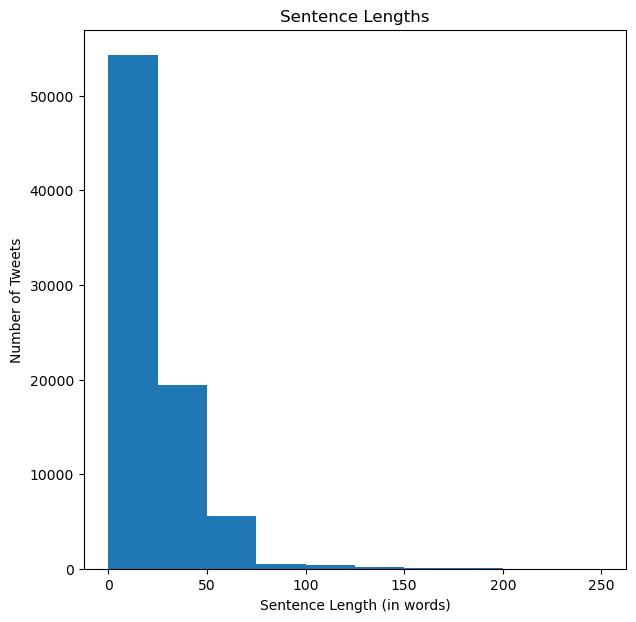

In [14]:
sentence_lengths = [len(tokens) for tokens in trading_hours_tweets['tokens']]
vocab = sorted(list(set([word for tokens in trading_hours_tweets['tokens'] for word in tokens])))

plt.figure(figsize = (7,7))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [15]:
print('We have a vocabulary size of', len(vocab), 'unique words')

We have a vocabulary size of 56077 unique words


### 3.2.5 Removing Stopwords

“Stop words” are the most common words in a language like “the”, “a”, “at”, “for”, “above”, “on”, “is”, “all”. These words do not provide any meaning and are usually removed from texts. We can remove these stop words using nltk library

In [16]:
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
trading_hours_tweets['tweet_without_stopwords'] = trading_hours_tweets['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### 3.2.6 Lemmitization

In simpler terms, lemmitization is the process of converting a word to its base form. Lemmatization considers the context and converts the word to its meaningful base form. For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care'. This is extremely valuable because we want to identify key words that lead to negative, positive and neutral sentiments.

In [17]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

trading_hours_tweets['tweet_lemmatized'] = trading_hours_tweets['tweet_without_stopwords'].apply(lemmatize_text)

## 3.3 Word Embedding

One of the features that we will be using to predict the adjusted closing price is the vectorized representation of the tweet. To get the numbers, we need to build a text classification model using word embedding.

**Text classification** can be applied to many different problems, including gauging the public opinion on social media. Historically, it is studied as news articles classification into a pre-determined set of classes, and based on the summary or the title or even the whole body of the article the machine learning models determine if the news article is about economy, sports, real state, and so on. It can also be used for classifying a company's documents into categories that will be analyzed only by the corresponding department. Finally, it can direct, for example, quantify public opinions by classifying the query of a ticker, allowing to gauge public sentiments and lead to accurate price prediction.

**Word embedding** is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Loosely speaking, they are vector representations of a particular word. In this project, we will use Word2Vec embedding method to map a word to a fixed-length vector. In simple terms, words that have similar meanings or are related closely, when mapped into a vector space would appear closer, like in a cluster. This can help us understand the semantics of the words in a sentence better than any previously mentioned technique.

Text classfication models performed in this project are Bags of words, TF-IDF, Word2Vec and BERT.

### 3.3.1 Building the Word2Vec Model

In [18]:
#Convertng all columns to Object type
trading_hours_tweets.astype('object')

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,Sentiment,...,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,clean_text,tokens,tweet_without_stopwords,tweet_lemmatized
0,2022-12-30,20:29:43,LlcBillionaire,0,Twitter Web App,10 New Yearâs food traditions around the world,0.454545,0.136364,Positive,1.0,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.125,8.0,1.0,0.125,new yearâ food tradition around the world,"[new, yearâ, food, tradition, around, the, world]",new yearâ food tradition around world,"[new, yearâ, food, tradition, around, world]"
1,2022-12-30,20:29:32,skitontop1,0,Twitter Web App,Entries &amp; exits Daily! \nDiscord link belo...,0.5,0.3,Positive,1.0,...,0,"{'! count': 1, '"" count': 0, '# count': 0, '$ ...",7.428571,3.5,1.0,0.0,entrie amp exit daily \ndi cord link belo...,"[entrie, amp, exit, daily, di, cord, link, bel...",entrie amp exit daily di cord link belowð,"[entrie, amp, exit, daily, di, cord, link, bel..."
2,2022-12-30,20:29:28,StockJobberOG,0,Twitter Web App,$AAPL $MSFT $SPY $TSLA $AMZN $BRK.B\n\n,0.0,0.0,Neutral,0.0,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.166667,6.0,1.0,0.0,aapl m ft py t la amzn brk b\n\n,"[aapl, m, ft, py, t, la, amzn, brk, b]",aapl ft py la amzn brk b,"[aapl, ft, py, la, amzn, brk, b]"
3,2022-12-30,20:29:20,ItsJennyJ,0,Twitter for Android,@Apple I have an Apple ipod from 2012.\nI'd li...,0.0,0.0,Neutral,0.0,...,0,"{'! count': 0, '"" count': 0, '# count': 2, '$ ...",4.705882,6.8,0.794118,0.411765,i have an apple ipod from \ni d like to tar...,"[i, have, an, apple, ipod, from, i, d, like, t...",apple ipod like tart u ing apple id order tart...,"[apple, ipod, like, tart, u, ing, apple, id, o..."
4,2022-12-30,20:29:11,LlcBillionaire,0,Twitter Web App,The biggest â and maybe the best â financi...,0.15,0.5,Positive,1.0,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",5.16129,31.0,0.903226,0.419355,the bigge t â and maybe the be t â financi...,"[the, bigge, t, â, and, maybe, the, be, t, â, ...",bigge â maybe â financial olution hould u ...,"[bigge, â, maybe, â, financial, olution, h..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80420,2022-12-29,13:30:04,jrpurdon,0,Twitter Web App,@deazasvo @shaun_vids But no one was trying to...,0.5125,-0.15,Negative,-1.0,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.21875,10.666667,0.90625,0.375,but no one wa trying to pa law to force y...,"[but, no, one, wa, trying, to, pa, law, to, fo...",one wa trying pa law force vaccinate entirely ...,"[one, wa, trying, pa, law, force, vaccinate, e..."
80421,2022-12-29,13:30:03,drinkie,2,Twitter for iPad,That is brilliant from @Apple got my mouse mov...,0.65,0.95,Positive,1.0,...,0,"{'! count': 1, '"" count': 0, '# count': 0, '$ ...",6.111111,27.0,1.0,0.333333,that i brilliant from got my mou e moving be...,"[that, i, brilliant, from, got, my, mou, e, mo...",brilliant got mou e moving imac de ktop macboo...,"[brilliant, got, mou, e, moving, imac, de, kto..."
80422,2022-12-29,13:30:03,healthysupplies,1,Buffer,Our #RecipeOfTheDay is apple and cinnamon spic...,0.569444,0.227778,Positive,1.0,...,0,"{'! count': 2, '"" count': 0, '# count': 1, '$ ...",5.684211,9.5,0.921053,0.368421,our recipeoftheday i apple and cinnamon pic...,"[our, recipeoftheday, i, apple, and, cinnamon,...",recipeoftheday apple cinnamon piced chia puddi...,"[recipeoftheday, apple, cinnamon, piced, chia,..."
80423,2022-12-29,13:30:02,NicheMktMedia,0,Buffer,What Are The Best Apple IPhone Cases,0.3,1.0,Positive,1.0,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",5.285714,7.0,1.0,0.0,what are the be t apple iphone ca e,"[what, are, the, be, t, apple, iphone, ca, e]",apple iphone ca e,"[apple, iphone, ca, e]"


### 3.3.2 Train Test Split

In [19]:
X = trading_hours_tweets.tweet_lemmatized.values.reshape(-1,1)
y = trading_hours_tweets.Sentiment.values
print(type(X), type(y))
print(y.shape, X.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(80425,) (80425, 1)


Define a training set and test set (80/20 ratio)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

As far as we know, computers can only understand numerical data, while natural language data, for computers, are just text strings without any numerical or statistical information. So, how do we make computers understand text data?

By converting texts to numbers and also conserving linguistic information for analysis.

But before feeding lists of tokens into the Word2Vec model, we must turn them into LabeledSentence objects beforehand. Here's how to do it:

In [21]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

X_train = labelizeTweets(X_train, 'TRAIN')
X_test = labelizeTweets(X_test, 'TEST')

64340it [00:00, 86642.67it/s] 
16085it [00:00, 307971.09it/s]


In [22]:
X_train[0]

TaggedDocument(words=array([list(['look', 'would', 'want', 'happy', 'pixel', 'watch', 'apple', 'watch', 'connected', 'cellular', 'air', 'ipad', 'might', 'bought', 'oneð\x9f¤\x93'])],
      dtype=object), tags=['TRAIN_0'])

Each element is basically some object with two attributes: a list (of tokens) and a label.

In [23]:
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,Sentiment,...,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,clean_text,tokens,tweet_without_stopwords,tweet_lemmatized
0,2022-12-30,20:29:43,LlcBillionaire,0,Twitter Web App,10 New Yearâs food traditions around the world,0.454545,0.136364,Positive,1.0,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.125000,8.0,1.000000,0.125000,new yearâ food tradition around the world,"[new, yearâ, food, tradition, around, the, world]",new yearâ food tradition around world,"[new, yearâ, food, tradition, around, world]"
1,2022-12-30,20:29:32,skitontop1,0,Twitter Web App,Entries &amp; exits Daily! \nDiscord link belo...,0.500000,0.300000,Positive,1.0,...,0,"{'! count': 1, '"" count': 0, '# count': 0, '$ ...",7.428571,3.5,1.000000,0.000000,entrie amp exit daily \ndi cord link belo...,"[entrie, amp, exit, daily, di, cord, link, bel...",entrie amp exit daily di cord link belowð,"[entrie, amp, exit, daily, di, cord, link, bel..."
2,2022-12-30,20:29:28,StockJobberOG,0,Twitter Web App,$AAPL $MSFT $SPY $TSLA $AMZN $BRK.B\n\n,0.000000,0.000000,Neutral,0.0,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.166667,6.0,1.000000,0.000000,aapl m ft py t la amzn brk b\n\n,"[aapl, m, ft, py, t, la, amzn, brk, b]",aapl ft py la amzn brk b,"[aapl, ft, py, la, amzn, brk, b]"
3,2022-12-30,20:29:20,ItsJennyJ,0,Twitter for Android,@Apple I have an Apple ipod from 2012.\nI'd li...,0.000000,0.000000,Neutral,0.0,...,0,"{'! count': 0, '"" count': 0, '# count': 2, '$ ...",4.705882,6.8,0.794118,0.411765,i have an apple ipod from \ni d like to tar...,"[i, have, an, apple, ipod, from, i, d, like, t...",apple ipod like tart u ing apple id order tart...,"[apple, ipod, like, tart, u, ing, apple, id, o..."
4,2022-12-30,20:29:11,LlcBillionaire,0,Twitter Web App,The biggest â and maybe the best â financi...,0.150000,0.500000,Positive,1.0,...,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",5.161290,31.0,0.903226,0.419355,the bigge t â and maybe the be t â financi...,"[the, bigge, t, â, and, maybe, the, be, t, â, ...",bigge â maybe â financial olution hould u ...,"[bigge, â, maybe, â, financial, olution, h..."


In [24]:
trading_hours_tweets.to_csv('/Users/user/Documents/Springboard_Data_Science/Capstone_2_Twitter_Sentiment_Analysis/Data/03_tweets_data.csv', index=False)